# Creating a Kaggle Workflow

Kaggle is a website that contains over 50,000 datasets and 400,000 public notebooks for users to use in their data science work. They also offer machine learning competitions, where user compete to make the best predictions for a given dataset. One of these machine learning competitions is the Titanic competition, where you are given train and test sets of data for all of the passengers on the Titanic. The train set includes the 'Survival' column, which is 1 if the passenger survived and 0 if they did not survive; the test set does not include this column. The goal of the project is to create a machine learning algorithm that best predicts for the test set which passengers survived and which didn't. Competitors save their predictions from their machine learning algorithm, along with the passenger id's, to a .csv file and upload it to Kaggle, where it is checked for accuracy.

The goal of this project is to explore a workflow to make competing in the Kaggle Titanic competition easier by using a pipeline of functions.

I'll begin by importing the train and test sets.

In [1]:
import pandas as pd
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In the missions before starting this project, I created various functions to use in the Titanic competition. I will now load these using the Jupyter %load  command

In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

I will now create a function that applies all of these functions to the dataframe, so that I can perform all of my data cleaning in one step.

In [3]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    for col in ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']:
        df = create_dummies(df, col)
    return df

train = pre_process(train)
holdout = pre_process(holdout)

print(train.info())
print(holdout.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 43 columns):
PassengerId                   891 non-null int64
Survived                      891 non-null int64
Pclass                        891 non-null int64
Name                          891 non-null object
Sex                           891 non-null object
Age                           891 non-null float64
SibSp                         891 non-null int64
Parch                         891 non-null int64
Ticket                        891 non-null object
Fare                          891 non-null float64
Embarked                      891 non-null object
Age_categories                891 non-null category
Fare_categories               891 non-null category
Title                         891 non-null object
Cabin_type                    891 non-null object
Age_categories_Missing        891 non-null uint8
Age_categories_Infant         891 non-null uint8
Age_categories_Child          891 non-null uin

### Exploring the Data

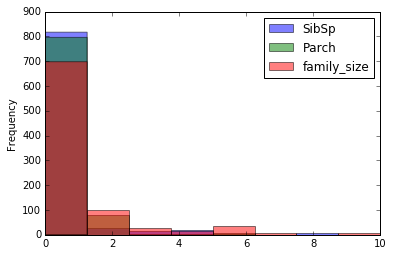

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

explore_cols = ['SibSp', 'Parch']
explore = train[explore_cols].copy()
explore['family_size'] = explore[explore_cols].sum(axis=1)
explore_cols.append('family_size')

explore.plot.hist(alpha = .5, bins=8)

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can get the number of family members each passenger has by summing the SibSp and Parch columns. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

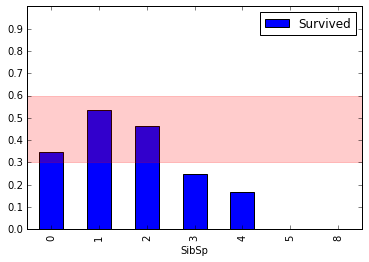

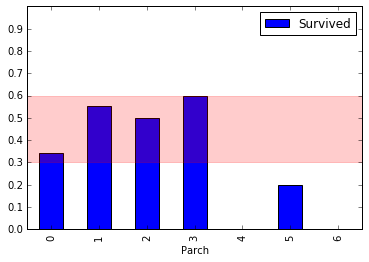

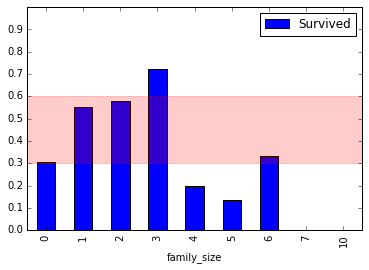

In [5]:
explore['Survived'] = train['Survived']

for col in explore_cols:
    pivot = explore.pivot_table(index=col, values='Survived')
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

Looking at the survival rates of family_size, you can see that the majority of passengers who survived had some family members on board.

Let's use this to create a new feature, isalone, that determines if the passenger was alone or not.
- 1 if passenger has 0 family members on board
- 0 if passenger has one or more family members on board

In [6]:
def process_isalone(df):
    df['family_size'] = df[['SibSp', 'Parch']].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["family_size"] == 0),"isalone"] = 1
    df = df.drop("family_size",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)
train['isalone'].value_counts()

1    537
0    354
Name: isalone, dtype: int64

### Feature Selection

scikit-learn's feature_selection.RFECV class automates selecting the best-performing features using recursive feature elimination. I will create a function that implements the RFECV class, using the Random Forests algorithm as an estimator.

In [9]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    # Drop non-numeric cols and cols containing null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(['PassengerId', 'Survived'], axis=1)
    all_y = df['Survived']
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    
    best_features = list(all_X.columns[selector.support_])
    print("Best Features:\n", best_features)
    
    return best_features

features = select_features(train)

Best Features:
 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



### Parameter Selection

sklearn's model_selection.GridSearchCV class allows us to find the best set of performing parameters. 

I will create a function that will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df,features):
    all_X = df[features]
    all_y = df['Survived']

    # List of dictionaries, each containing a model name, it's estimator and a dict of hyperparameters
    models = [
        {
            'name': 'LogisticRegression',
            'estimator': LogisticRegression(),
            'hyperparameters':
                {
                    'solver': ['newton-cg', 'lbfgs', 'liblinear']
                }
        },
        {
            'name': 'KNeighborsClassifier',
            'estimator': KNeighborsClassifier(),
            'hyperparameters':
                {
                    'n_neighbors': range(1,20,2),
                    'weights': ['distance', 'uniform'],
                    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                    'p': [1,2]
                }
        },
        {
            'name': 'RandomForestClassifier',
            'estimator': RandomForestClassifier(random_state=1),
            'hyperparameters':
                {
                    'n_estimators': [4, 6, 9],
                    'criterion': ['entropy', 'gini'],
                    'max_depth': [2, 5, 10],
                    'max_features': ['log2', 'sqrt'],
                    'min_samples_leaf': [1, 5, 8],
                    'min_samples_split': [2, 3, 5]

                }
        }
    ]

    for model in models:
        print('{}: '.format(model['name']))

        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X,all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_

        print('Best Score: ', model['best_score'])
        print('Best Parameters: ', model['best_params'])
        print('_' * 20, '\n')

    return models

result = select_model(train, features)

LogisticRegression: 
Best Score:  0.8204264870931538
Best Parameters:  {'solver': 'liblinear'}
____________________ 

KNeighborsClassifier: 
Best Score:  0.7755331088664422
Best Parameters:  {'n_neighbors': 5, 'algorithm': 'brute', 'weights': 'uniform', 'p': 1}
____________________ 

RandomForestClassifier: 
Best Score:  0.8294051627384961
Best Parameters:  {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 4, 'min_samples_leaf': 1, 'criterion': 'entropy', 'max_features': 'log2'}
____________________ 



### Making a submission to Kaggle

I will write a function that accepts a trained model and a list of columns as required arguments, and an optional filename_argument

In [12]:
def save_submission_file(model, features, filename="submission.csv"):
    holdout_data = holdout[features]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)
    

In [15]:
best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model, features)    